In [1]:
import pandas as pd
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [2]:
dfPitloc = pd.read_excel('Pitloc.xlsx')
dfPitloc.head()
dfPitloc.drop([i for i in dfPitloc.columns if i not in ['id', 'xloc','yloc', 'zloc']], axis=1, inplace = True)
dfPitloc.head()

,id,xloc,yloc,zloc
0,BOT,28497,82023,4500.000000
1,C-ENTRENAMIENTO,28419,79699,4603.000000
2,CAPELLA,0,76000,4837.200195
3,CO01,38394,79907,4365.100098
4,CS01,38309,79873,4367.200195


In [3]:
Coordenadas = {}
xyznodos = {}

for index, row in dfPitloc.iterrows():
    xyznodos[row[0]] = {'xloc': row[1], 'yloc': row[2], 'zloc': row[3]}
    Coordenadas[row[0]] = {'pos':(row[1], row[2]) }


In [4]:
df = pd.read_excel('Travel.xlsx')
df.columns = df.iloc[0]
df.drop(0, inplace = True)


In [5]:
Y = []
DX = []
DY = []
DZ = []
for index, row in df.iterrows():
    ni = row['locstart']
    nt = row['locend']
    deltaX = abs(xyznodos[ni]['xloc']-xyznodos[nt]['xloc'])
    deltaY = abs(xyznodos[ni]['yloc']-xyznodos[nt]['yloc'])
    deltaZ = xyznodos[ni]['zloc']-xyznodos[nt]['zloc']
    DX.append(deltaX)
    DY.append(deltaY)
    DZ.append(deltaZ)
    Y.append(deltaZ/((deltaX**2+deltaY**2)**(1/2))*100)
    #print('    deltaX: {}'.format(deltaX))
    #print('    deltaY: {}'.format(deltaY))
    #print('    deltaZ: {}'.format(deltaZ))
    #print('    Pendiente:  {}'.format(deltaZ/((deltaX**2+deltaY**2)**(1/2))*100))
    
dfCoordenadas = pd.DataFrame(list(zip(Y, DX, DY, DZ)), columns =['Y', 'Delta X', 'Delta Y', 'Delta Z'])
dfCoordenadas.head()

#Y = dfCoordenadas['Y']
#X = dfCoordenadas[['Delta X', 'Delta Y', 'Delta Z']]

y = pd.DataFrame(dfCoordenadas['Y'])
X = pd.DataFrame(dfCoordenadas[['Delta X', 'Delta Y', 'Delta Z']])

#X_train, X_test, y_train, y_test = train_test_split(X, Y)

model = LinearRegression()
scores = []
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X, y)):
    model.fit(X.iloc[train,:], y.iloc[train,:])
    score = model.score(X.iloc[test,:], y.iloc[test,:])
    print('Coeficientes: {}'.format(model.coef_))
    scores.append(score)


myvals = np.array([107, 204, 3.7]).reshape(1, -1)
#print('Predicción: {}'model.predict(myvals))

Coeficientes: [[-1.20821228e-04 -2.85358421e-04  3.29357021e-01]]
Coeficientes: [[-0.00043257  0.00035172  0.32391813]]
Coeficientes: [[ 5.82989265e-04 -7.50849840e-05  3.45437236e-01]]


In [6]:
Arcos = []
for index, row in df.iterrows():
    Arcos.append([row[2], row[3], row[7], row[8], row[9], row[6]])

In [26]:
%matplotlib notebook
G = nx.DiGraph()
contar = 0
for edge in Arcos:
    if edge[4] == 0:
        #print(edge[0], edge[1])
        G.add_edge(edge[0], edge[1], time_empty = edge[2], time_loaded = edge[3], color = 'b')
    else:
        contar +=1
        #print(edge[0], edge[1])
        G.add_edge(edge[0], edge[1], time_empty = edge[2], time_loaded = edge[3], color = 'r')
'-----------------------------------------------------------------------------------------------------'
SCC = [len(i) for i in nx.strongly_connected_components(G)]
'-----------------------------------------------------------------------------------------------------'
nx.is_strongly_connected(G)
nx.set_node_attributes(G, Coordenadas)
Nodos = list(G.nodes())
colors = [G[u][v]['color'] for u,v in G.edges]
print("Arcos cerrados: {}".format(contar))

Arcos cerrados: 183


<IPython.core.display.Javascript object>


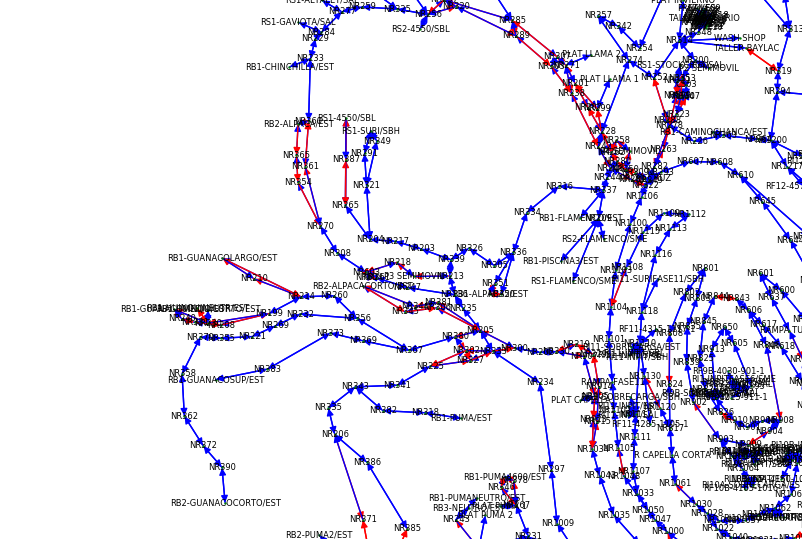

In [37]:
%matplotlib notebook
nx.draw(G, nx.get_node_attributes(G, 'pos'), with_labels=True, font_size = 6,node_size=0.5, node_color = 'g',edge_color = colors, weight = 'time_loaded')

In [9]:
SCC = [len(i) for i in nx.strongly_connected_components(G)]
largest = max(nx.strongly_connected_components(G), key=len)

<IPython.core.display.Javascript object>


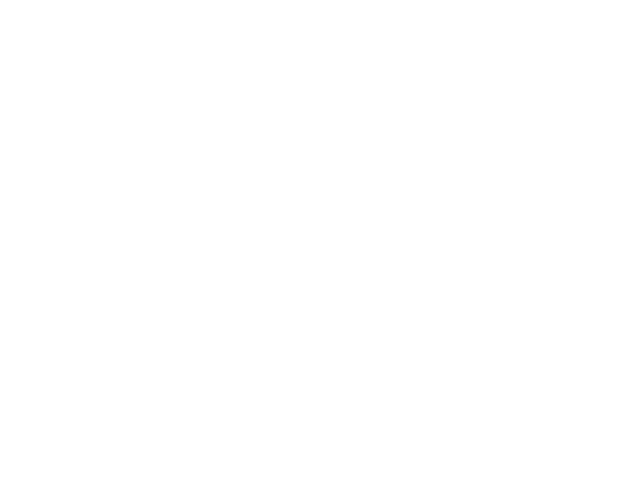

In [10]:
%matplotlib notebook
nombres = [i for i in range(len(Arcos))]
x_coords = [arco[5] for arco in Arcos]
y_coords = [arco[3]/60 for arco in Arcos]
for i, nombre in enumerate(nombres):
    x = x_coords[i]
    y = y_coords[i]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x, y, nombre, fontsize= 6)
plt.title("Time loaded vs Distance")
plt.xlabel('Distancia (m)')
plt.ylabel('Tiempo (minutos)')
plt.show()   

<IPython.core.display.Javascript object>


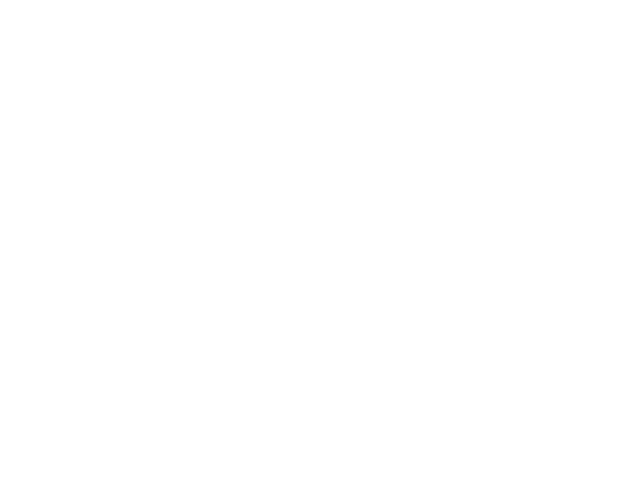

In [11]:
%matplotlib notebook
nombres = [i for i in range(len(Arcos))]
x_coords = [arco[5] for arco in Arcos]
y_coords = [arco[2]/60 for arco in Arcos]

for i, nombre in enumerate(nombres):
    x = x_coords[i]
    y = y_coords[i]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x, y, nombre, fontsize = 6)
plt.title("Time empty vs Distance")
plt.xlabel('Distancia (m)')
plt.ylabel('Tiempo (minutos)')
plt.show()   

<IPython.core.display.Javascript object>


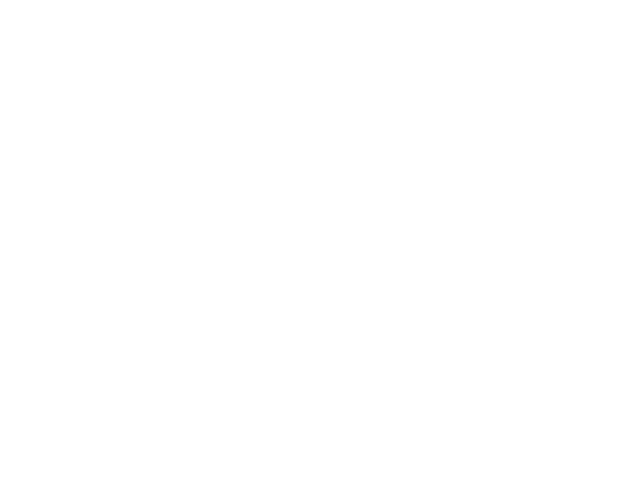

In [12]:
%matplotlib notebook
df['timeempty'].plot.hist(bins=300, alpha=0.5)

<IPython.core.display.Javascript object>


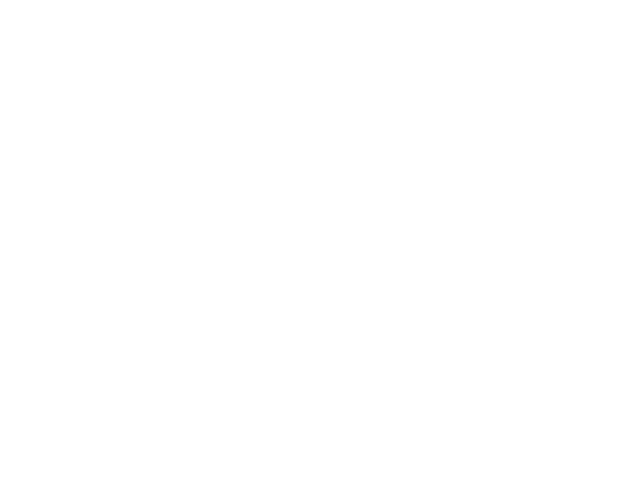

In [13]:
%matplotlib notebook
df['timeloaded'].plot.hist(bins=300, alpha=0.5)

In [32]:
print(nx.shortest_path_length(G, source='CS03', target='RS1-FLAMENCO/SME', weight='time_empty', method='dijkstra'))
print(nx.shortest_path_length(G, source='NR353', target='NR311', weight='time_empty', method='dijkstra'))
print(nx.shortest_path_length(G, source='NR311', target='RS1-STOCKCR04/SAL', weight='time_empty', method='dijkstra'))
print(nx.shortest_path(G, source='CS03', target='RS1-STOCKCR04/SAL', weight='time_empty', method='dijkstra'))
list(G.neighbors('RS1-STOCKCR04/SAL'))
#G.nodes()

265
5
12
['CS03', 'NR353', 'NR311', 'RS1-STOCKCR04/SAL']


['NR311']